# Final Project - Group 8

In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, make_scorer, f1_score, precision_recall_fscore_support,
                             silhouette_score, calinski_harabasz_score, davies_bouldin_score,
                             adjusted_rand_score, normalized_mutual_info_score, homogeneity_score)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.manifold import TSNE

from scipy.signal import welch
from xgboost import XGBClassifier
from typing import Literal

import joblib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.gridspec as gridspec

## Preprocessing

### Format the data into pandas.DataFrame
After this preprocessing procedure, we can easily get the data as a DataFrame through pandas

In [2]:
def get_data(flag: Literal['train', 'test']) -> tuple[pd.DataFrame, pd.Series]:
    """
    Load and process the UCI HAR Dataset for the specified data type ('train' or 'test').
    :param flag: A string indicating the type of data to load ('train' or 'test').
    :return: A pandas DataFrame containing the processed data with features and labels.
    """

    # Read the data from the text files and create a DataFrame
    return (pd.DataFrame((line.strip().split() for line in open(f'UCI HAR Dataset/{flag}/X_{flag}.txt', 'r')),
                         columns=(feature.split()[1] for feature in open(
                             'UCI HAR Dataset/features.txt', 'r')),
                         dtype=np.float64),
            pd.Series((label.strip() for label in open(
                # Adjust labels to be zero-indexed
                f'UCI HAR Dataset/{flag}/y_{flag}.txt')), name='label').astype(np.int8)-1)

### Describe the data and check invalid values
As we can see, there is no invalid values and all data has been normalized to $[-1,1]$.  
So there is no need to do more normalization.  

In [3]:
# fetch the data
# X_train, y_train = get_data('train')
# X_test, y_test = get_data('test')

# Since the preprocessing has been done and the data is already available in CSV format,
# we can directly load the data from CSV files to avoid reprocessing.
X_train_df = pd.read_csv('data/X_train.csv')
y_train_df = pd.read_csv('data/y_train.csv')
X_test_df = pd.read_csv('data/X_test.csv')
y_test_df = pd.read_csv('data/y_test.csv')

# Convert the DataFrames to numpy arrays
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

# Standardize to improve the model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # check the data again
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train_df.isnull().sum().sum(), y_train_df.isnull().sum())
print(X_test_df.isnull().sum().sum(), y_test_df.isnull().sum())
print(np.isinf(X_train).sum().sum(), np.isinf(y_train).sum())
print(np.isinf(X_test).sum().sum(), np.isinf(y_test).sum())

print(X_train_df.describe())


feature_columns = X_train_df.columns

(7352, 561) (7352, 1)
(2947, 561) (2947, 1)
0 label    0
dtype: int64
0 label    0
dtype: int64
0 0
0 0
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695          -0.109141   
std             0.070261           0.040811           0.056635   
min            -1.000000          -1.000000          -1.000000   
25%             0.262975          -0.024863          -0.120993   
50%             0.277193          -0.017219          -0.108676   
75%             0.288461          -0.010783          -0.097794   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       7352.000000       7352.000000       7352.000000       7352.000000   
mean          -0.605438         -0.510938         -0.604754         -0.630512   
std            0.448734          0.502645          0.41868

### Save the data into csv files

In [4]:
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

## Visualization

### Arrange the data

In [5]:
# Load the training dataset containing features
df = pd.concat([X_train_df, X_test_df], axis=0, ignore_index=True)

# Load the labels corresponding to the training dataset
labels = pd.concat([y_train_df, y_test_df], axis=0,
                   ignore_index=True).values.flatten()

# Load the activity labels from the text file
label_names = pd.read_csv('data/activity_labels.txt',
                          header=None, names=['name'])

### Time-domain Features

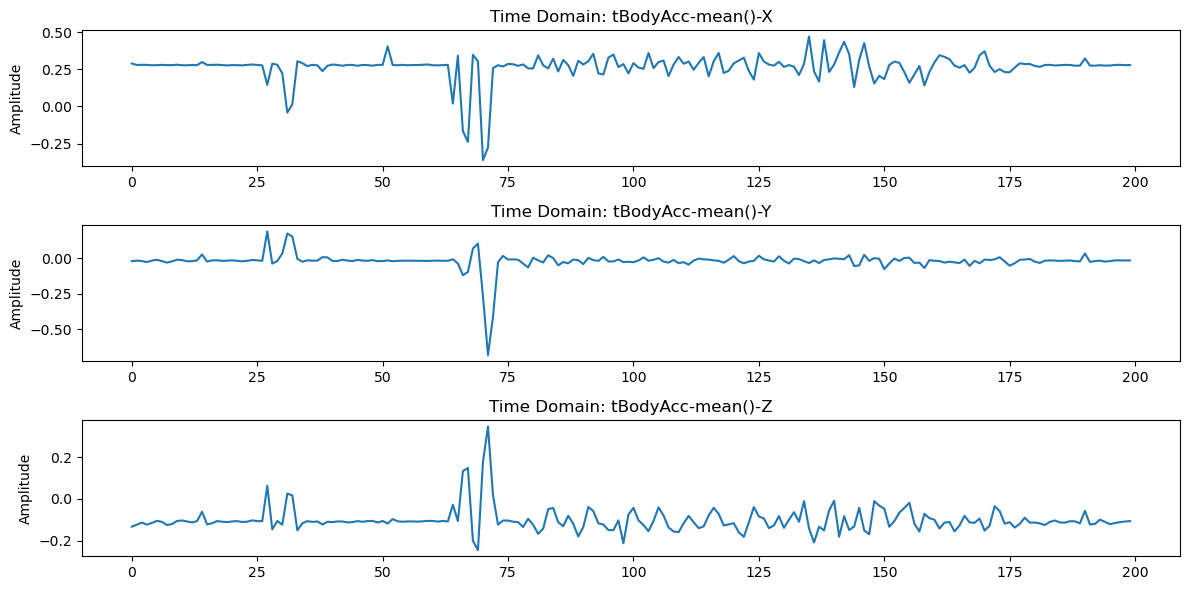

In [6]:
# Select specific time-domain features from the DataFrame
time_features = df[['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y',
                    'tBodyAcc-mean()-Z']]
# Plot the time-domain features
plt.figure(figsize=(12, 6))  # Set the figure size
for i, col in enumerate(time_features.columns):
    plt.subplot(3, 1, i+1)  # Create a subplot for each feature
    plt.plot(time_features[col].values[:200])  # Plot the first 200 samples
    plt.title(f'Time Domain: {col}')  # Set the title for each subplot
    plt.ylabel('Amplitude')  # Label the y-axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot

### t-SNE Visualization

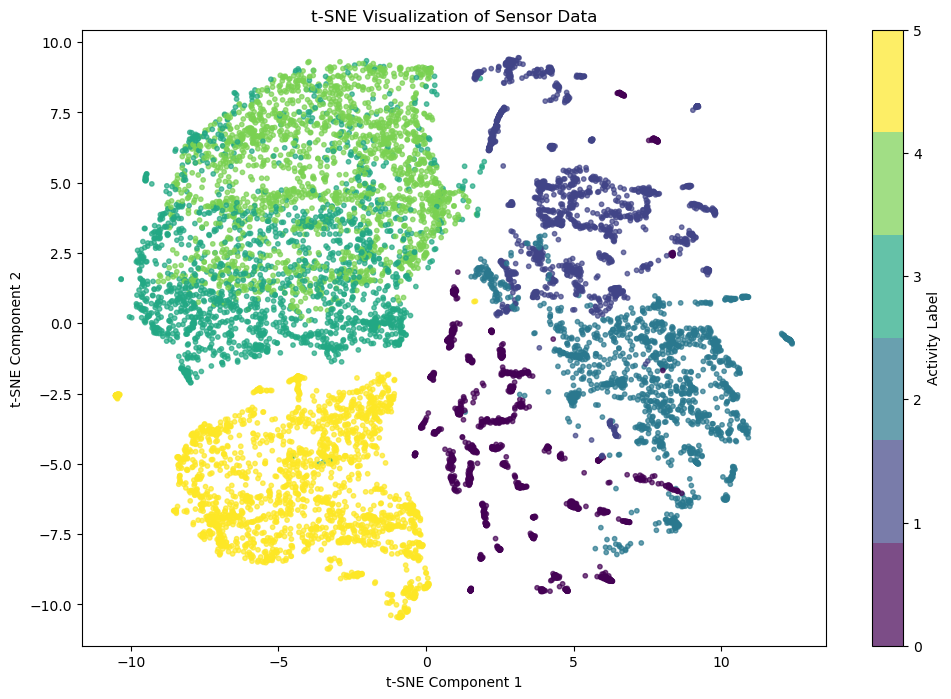

In [7]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(
    n_components=2,  # Reduce to 2 dimensions for visualization
    perplexity=30,  # Controls the balance between local and global aspects
    max_iter=300,  # Maximum number of iterations for optimization
    learning_rate=200,  # Step size for optimization
    random_state=42  # Ensure reproducibility
)
tsne_embeddings = tsne.fit_transform(df)

# Visualize the t-SNE results
plt.figure(figsize=(12, 8))  # Set the figure size
scatter = plt.scatter(
    tsne_embeddings[:, 0],  # First t-SNE component
    tsne_embeddings[:, 1],  # Second t-SNE component
    c=labels,  # Use activity labels for coloring
    cmap=plt.get_cmap("viridis", np.max(labels)+1),  # Colormap for labels
    s=10,  # Marker size
    alpha=0.7  # Transparency of markers
)
plt.colorbar(scatter, ticks=np.unique(labels),
             label="Activity Label")  # Add colorbar with labels
plt.title("t-SNE Visualization of Sensor Data")  # Set the plot title
plt.xlabel("t-SNE Component 1")  # Label for x-axis
plt.ylabel("t-SNE Component 2")  # Label for y-axis
plt.show()  # Display the plot

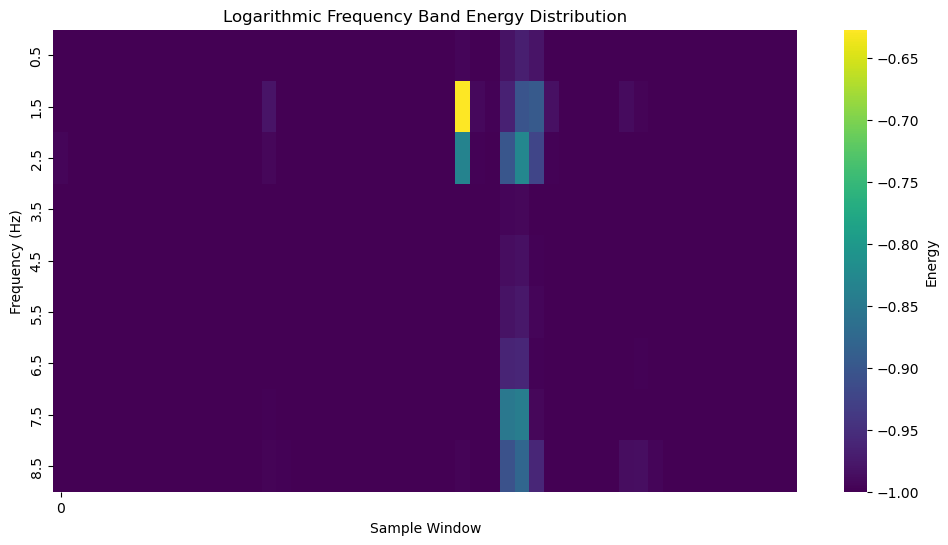

In [8]:

# Select specific frequency band energy features (example: 1-16Hz frequency band)
freq_bands = df.filter(regex='bandsEnergy\\(\\)-1,16')

# Create a logarithmic frequency range for the y-axis (1-16Hz, logarithmic scale)
# Logarithmic distribution from 1Hz to 16Hz
freq_range = np.logspace(0, np.log10(16), num=9)

plt.figure(figsize=(12, 6))  # Set the figure size
sns.heatmap(
    freq_bands.iloc[:50].T,  # Transpose and display the first 50 samples
    cmap="viridis",  # Use the "viridis" colormap
    cbar_kws={"label": "Energy"},  # Add a color bar with the label "Energy"
    xticklabels=50,  # Set x-axis tick labels to show every 50th sample
    # Round the frequency range to 1 decimal place for y-axis labels
    yticklabels=freq_range.round(1)
)
# Set the plot title
plt.title("Logarithmic Frequency Band Energy Distribution")
plt.xlabel("Sample Window")  # Label for the x-axis
plt.ylabel("Frequency (Hz)")  # Label for the y-axis

# Format the y-axis to display frequency values with one decimal place
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x:.1f}")
)

# Display the plot
plt.show()

### Energy Distribution of Frequency Bands

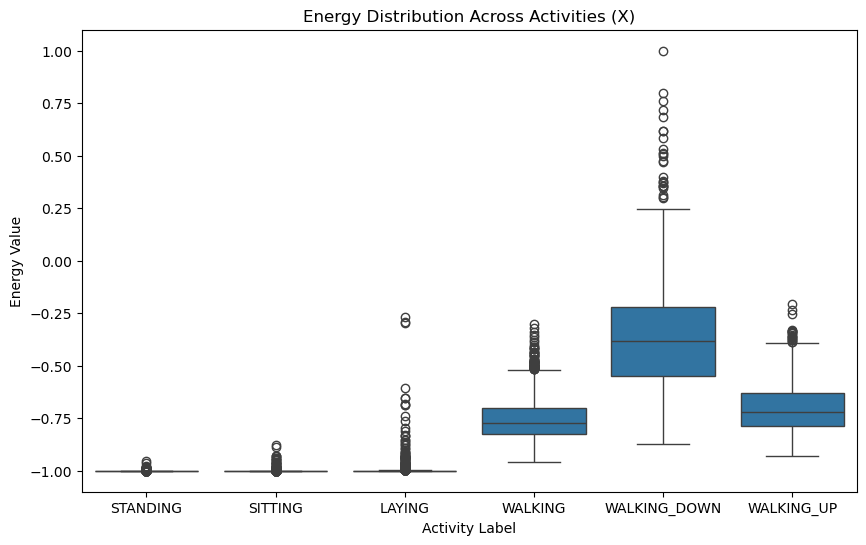

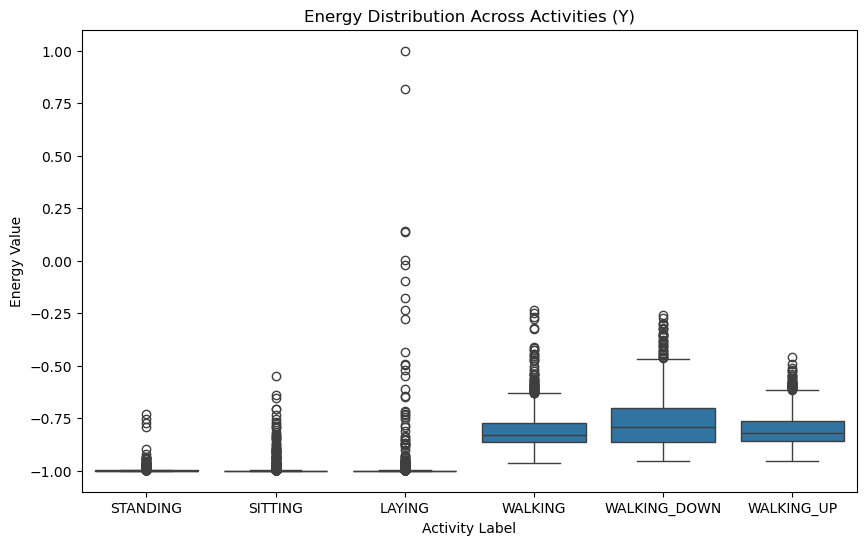

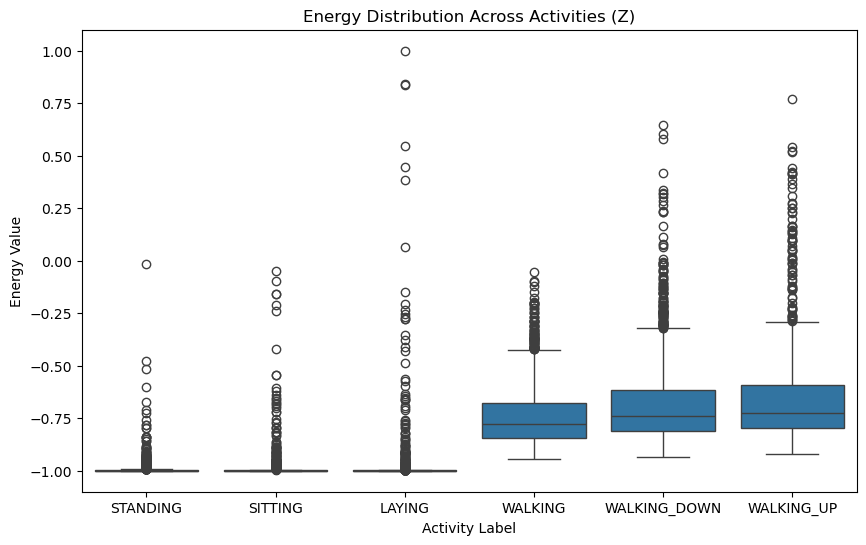

In [9]:
# Select energy features for the X, Y, and Z axes of body acceleration
energy_features = df.loc[:, [
    'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z']]

# Add the activity labels as a new column to the energy features DataFrame
energy_features['label'] = label_names.loc[labels, 'name'].values

# Create a boxplot to visualize the distribution of energy values for the X-axis
# across different activity labels
for ax in ['X', 'Y', 'Z']:
    plt.figure(figsize=(10, 6))  # Set the figure size
    sns.boxplot(x='label', y=f'tBodyAcc-energy()-{ax}',
                data=energy_features)  # Create the boxplot
    # Set the plot title
    plt.title(f'Energy Distribution Across Activities ({ax})')
    plt.xlabel('Activity Label')  # Label for the x-axis
    plt.ylabel('Energy Value')  # Label for the y-axis
    plt.show()  # Display the plot

### Inter-axis Correlation Matrix

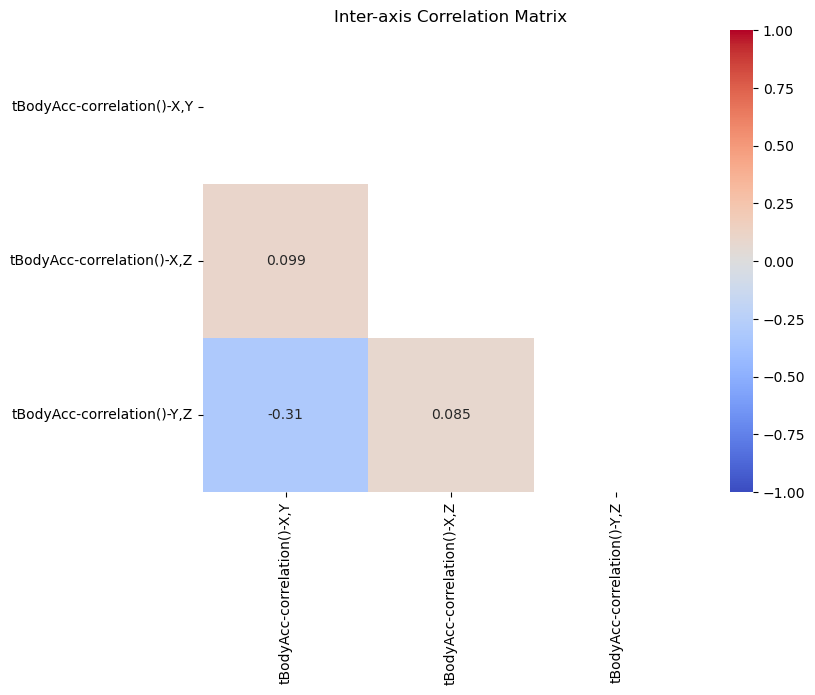

In [10]:
# Select accelerometer inter-axis correlation features
corr_features = df[['tBodyAcc-correlation()-X,Y',  # Correlation between X and Y axes
                    'tBodyAcc-correlation()-X,Z',  # Correlation between X and Z axes
                    'tBodyAcc-correlation()-Y,Z']]  # Correlation between Y and Z axes

# Create a figure with specified size
plt.figure(figsize=(8, 6))

# Generate a heatmap to visualize the correlation matrix
sns.heatmap(
    corr_features.corr(),  # Compute the correlation matrix of the selected features
    annot=True,  # Display correlation values on the heatmap
    cmap='coolwarm',  # Use the "coolwarm" colormap
    vmin=-1, vmax=1,  # Set the range of correlation values
    # Mask the upper triangle of the matrix
    mask=np.triu(np.ones_like(corr_features.corr()))
)

# Add a title to the heatmap
plt.title('Inter-axis Correlation Matrix')

# Display the heatmap
plt.show()

### Interquartile Range (IQR) and Entropy Features

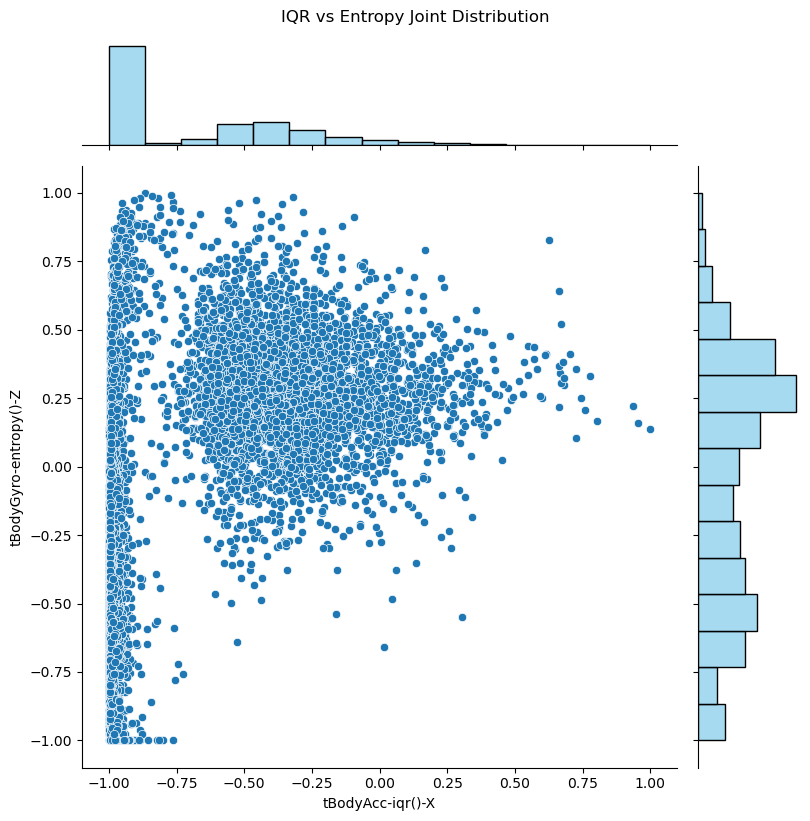

In [11]:
# Create a joint plot to visualize the relationship between two features:
# 'tBodyAcc-iqr()-X' (Interquartile Range of Body Acceleration on X-axis)
# and 'tBodyGyro-entropy()-Z' (Entropy of Body Gyroscope on Z-axis)
sns.jointplot(
    x='tBodyAcc-iqr()-X',  # Feature for the x-axis
    y='tBodyGyro-entropy()-Z',  # Feature for the y-axis
    data=df,  # Data source
    kind='scatter',  # Type of plot: scatter plot
    # Settings for marginal histograms
    marginal_kws={'bins': 15, 'color': 'skyblue'},
    height=8  # Size of the plot
)

# Add a title to the plot
plt.suptitle('IQR vs Entropy Joint Distribution', y=1.02)

# Display the plot
plt.show()

### Power Spectral Density (PSD)

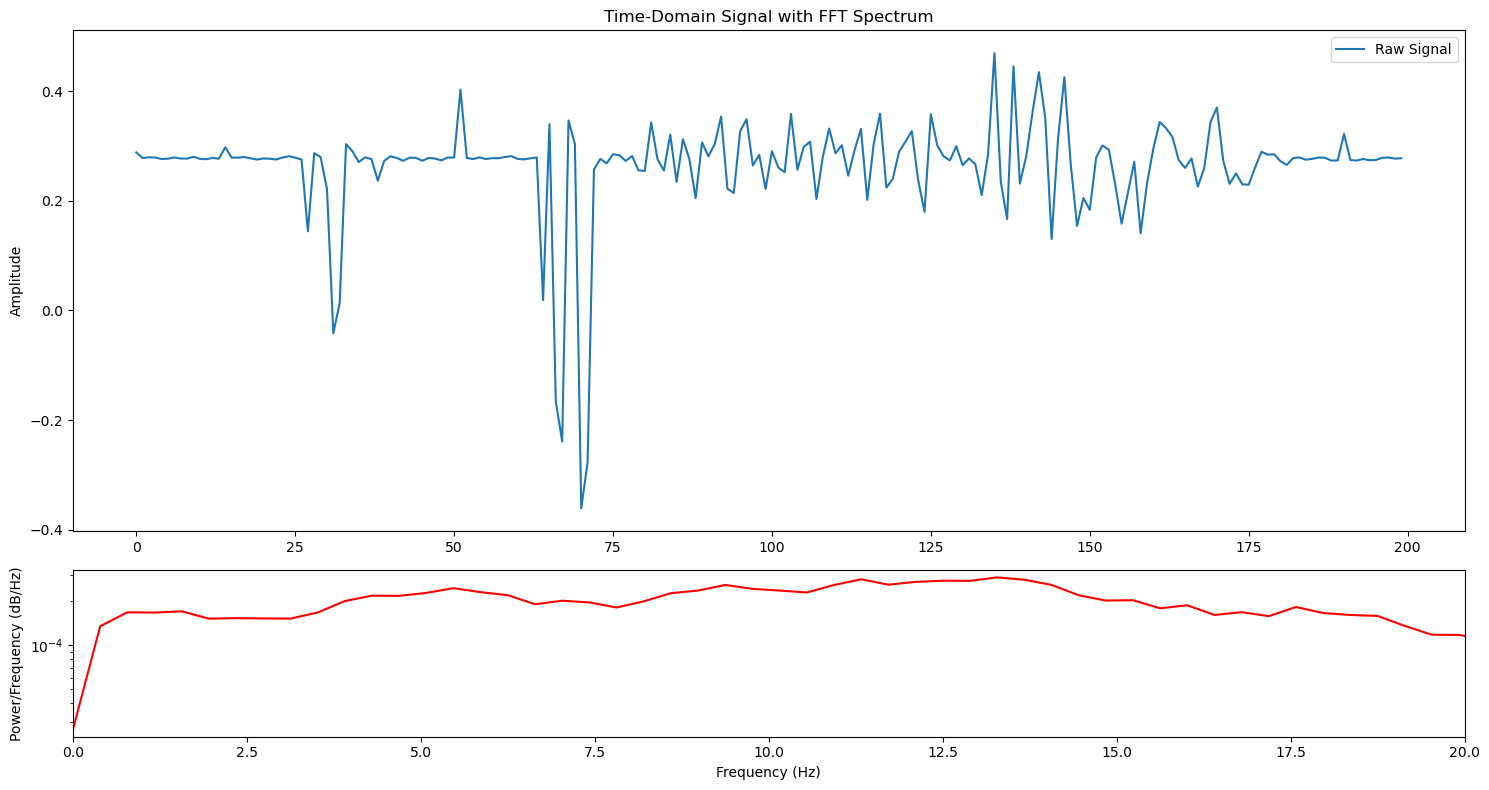

In [12]:
# Compute the Power Spectral Density (PSD) using Welch's method
fs = 50  # Sampling rate in Hz
# Compute PSD for the X-axis acceleration
f, Pxx = welch(df["tBodyAcc-mean()-X"], fs=fs, nperseg=128)

# Create a figure with a specified size
plt.figure(figsize=(15, 8))

# Use GridSpec to create a layout with two rows and one column
# The first row is 3 times taller than the second row
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Plot the time-domain signal
ax1 = plt.subplot(gs[0])  # Create a subplot for the time-domain signal
# Plot the first 200 samples of the signal
ax1.plot(df["tBodyAcc-mean()-X"][:200], label="Raw Signal")
# Set the title for the time-domain plot
ax1.set_title("Time-Domain Signal with FFT Spectrum")
ax1.set_ylabel("Amplitude")  # Label the y-axis
ax1.legend()  # Add a legend to the plot

# Plot the frequency-domain analysis (Power Spectral Density)
ax2 = plt.subplot(gs[1])  # Create a subplot for the frequency-domain analysis
# Plot the PSD on a logarithmic scale
ax2.semilogy(f, Pxx[:len(f)], color="red")
ax2.set_xlim(0, 20)  # Limit the x-axis to frequencies between 0 and 20 Hz
ax2.set_xlabel("Frequency (Hz)")  # Label the x-axis
ax2.set_ylabel("Power/Frequency (dB/Hz)")  # Label the y-axis

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Display the plots
plt.show()

## Cluster

### Data Preprocessing and Algorithm Preparation

In [ ]:
X = X_train_scaled  # Feature dimensions: (10299, 561)
y_true = y_train.flatten()

# PCA Dimensionality Reduction (for faster computation and visualization)
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)
print(f"Dimensions after PCA: {X_pca.shape[1]}")

N = 18
algorithms = {
    "K-Means": KMeans(n_clusters=N, init='k-means++', random_state=42, algorithm='elkan'),
    "Hierarchical": AgglomerativeClustering(n_clusters=N, linkage='ward'),
}

### Evaluation Function (Internal + External Metrics)

In [ ]:
def evaluate_clustering(X, labels, y_true=None):
    metrics = {}

    # Internal evaluation metrics
    if len(np.unique(labels)) > 1:  # Exclude single-cluster cases
        metrics['Silhouette'] = silhouette_score(X, labels)
        metrics['Calinski-Harabasz'] = calinski_harabasz_score(X, labels)
        metrics['Davies-Bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics.update(
            {'Silhouette': np.nan, 'Calinski-Harabasz': np.nan, 'Davies-Bouldin': np.nan})

    # External evaluation metrics (requires true labels)
    if y_true is not None:
        metrics['ARI'] = adjusted_rand_score(y_true, labels)
        metrics['NMI'] = normalized_mutual_info_score(y_true, labels)
        metrics['Homogeneity'] = homogeneity_score(y_true, labels)

    return metrics

### Perform Clustering and Evaluation

In [ ]:
results = {}
for name, model in algorithms.items():
    # Train clustering model
    cluster_labels = model.fit_predict(X_pca)

    # Compute evaluation metrics
    metrics = evaluate_clustering(X_pca, cluster_labels, y_true)
    results[name] = metrics

    # Print cluster distribution
    unique, counts = np.unique(cluster_labels, return_counts=True)

results_df = pd.DataFrame(results).T
print("\n\033[1m=== Clustering Performance Comparison ===\033[0m")
print(results_df)

### Visualization (PCA Reduced Space)

Dimensions after PCA: 102

=== K-Means Cluster Distribution ===
{0: 933, 1: 539, 2: 468, 3: 484, 4: 639, 5: 315, 6: 123, 7: 126, 8: 841, 9: 81, 10: 309, 11: 465, 12: 257, 13: 256, 14: 799, 15: 58, 16: 638, 17: 21}

=== Hierarchical Cluster Distribution ===
{0: 918, 1: 17, 2: 629, 3: 199, 4: 277, 5: 547, 6: 1106, 7: 94, 8: 1218, 9: 115, 10: 584, 11: 68, 12: 52, 13: 543, 14: 312, 15: 54, 16: 47, 17: 572}

=== Clustering Performance Comparison ===
              Silhouette  Calinski-Harabasz  Davies-Bouldin       ARI  \
K-Means         0.068109         864.015201        2.497302  0.315934   
Hierarchical    0.065765         812.100278        2.502543  0.383960   

                   NMI  Homogeneity  
K-Means       0.542716     0.673142  
Hierarchical  0.588519     0.702590  


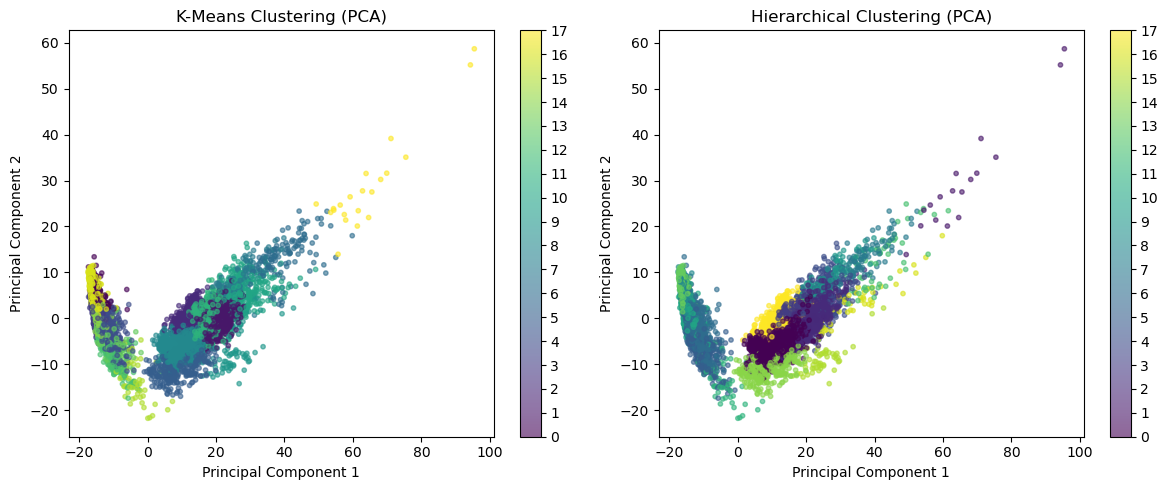

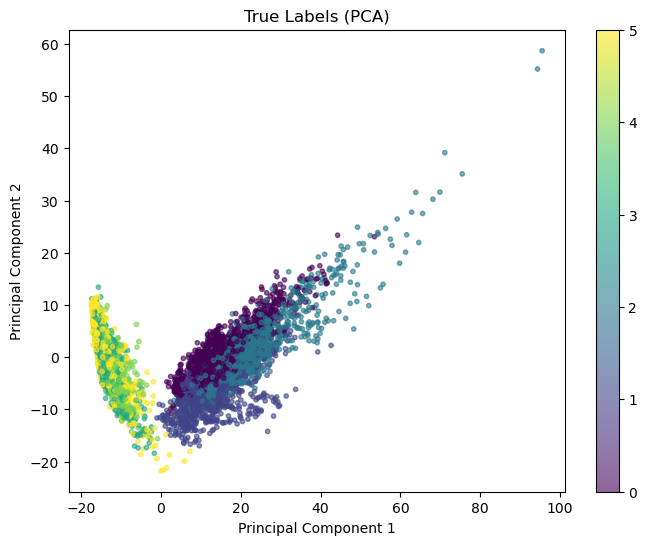

In [ ]:
plt.figure(figsize=(18, 5))
for i, (name, model) in enumerate(algorithms.items(), 1):
    cluster_labels = model.fit_predict(X_pca)

    # Plot predicted clusters
    plt.subplot(1, 3, i)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                          cmap='viridis', s=10, alpha=0.6)
    plt.title(f"{name} Clustering (PCA)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(scatter, ticks=np.unique(cluster_labels))

plt.tight_layout()
plt.show()

# Plot True Labels for Comparison
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true,
                      cmap='viridis', s=10, alpha=0.6)
plt.title("True Labels (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, ticks=np.unique(y_true))
plt.show()

## Prediction

### Model Training
##### Model Configuration Update & Enhanced Training Protocol

In [ ]:
MODEL_CONFIG = {
    'LogisticRegression': {
        'class': LogisticRegression,
        'params': {'max_iter': 1000, 'class_weight': 'balanced'}
    },
    'RandomForest': {
        'class': RandomForestClassifier,
        'params': {'n_estimators': 200, 'max_depth': 10, 'class_weight': 'balanced'}
    },
    'SVM': {
        'class': SVC,
        'params': {'kernel': 'rbf', 'C': 1.0, 'class_weight': 'balanced'}
    },
    'XGBoost': {
        'class': XGBClassifier,
        'params': {'eval_metric': 'logloss'}
    },
    'MLP': {
        'class': MLPClassifier,
        'params': {
            'hidden_layer_sizes': (100, 50),  # Two hidden layers
            'activation': 'relu',
            'solver': 'adam',
            'early_stopping': True,
            'max_iter': 500,
            'learning_rate_init': 0.001,
            'batch_size': 256
        }
    }
}


def train_models(X_train, y_train):
    trained_models = {}
    for model_name, config in MODEL_CONFIG.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()

        # model initialization
        model = config['class'](**config['params'])

        # Special handling for MLP convergence warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            model.fit(X_train, y_train)
        # Track loss curve for neural networks
        loss_curve = None
        if hasattr(model, 'loss_curve_'):
            loss_curve = model.loss_curve_

        # record the model date
        trained_models[model_name] = {
            'model': model,
            'train_time': time.time() - start_time,
            'feature_importances': getattr(model, 'feature_importances_', None),
            'loss_curve': loss_curve
        }

    return trained_models


trained_models = train_models(X_train_scaled, y_train)

### Neural Network-Specific Analysis
##### Add diagnostic visualizations. 

In [ ]:
def plot_neural_network_diagnostics(model_data):
    if model_data['loss_curve'] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(model_data['loss_curve'])
        plt.title('Training Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    # Visualize layer weights
    if isinstance(model_data['model'], MLPClassifier):
        weights = model_data['model'].coefs_
        plt.figure(figsize=(12, 6))
        for i, layer in enumerate(weights[:-1]):  # Exclude output layer
            plt.subplot(1, len(weights)-1, i+1)
            sns.heatmap(layer, cmap='viridis')
            plt.title(f'Layer {i+1} Weights')
        plt.tight_layout()
        plt.show()


def predict_all_sets(model, X_train, X_test):
    # Test the trained model on the training set, testing set and the entire set
    X_full = np.vstack([X_train, X_test])
    return {
        'train': model.predict(X_train),
        'test': model.predict(X_test),
        'full': model.predict(X_full)
    }


def evaluate_model(y_true, y_pred, dataset_name, model_name):
    # Generate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f'{model_name} - {dataset_name} Set Confusion Matrix')
    plt.show()

    return metrics


def compare_models(results):
    comparison = pd.DataFrame()
    for model_name, data in results.items():
        metrics = {
            'Train Accuracy': data['train']['accuracy'],
            'Test Accuracy': data['test']['accuracy'],
            'Full Accuracy': data['full']['accuracy'],
            'Train Precision': data['train']['precision'],
            'Test Precision': data['test']['precision'],
            'Full Precision': data['full']['precision'],
            'Train Recall': data['train']['recall'],
            'Test Recall': data['test']['recall'],
            'Full Recall': data['full']['recall'],
            'Train F1': data['train']['f1'],
            'Test F1': data['test']['f1'],
            'Full F1': data['full']['f1']
        }
        comparison[model_name] = pd.Series(metrics)
    return comparison.T


# Generate neural network diagnostics
for name, data in trained_models.items():
    if name == 'MLP':
        plot_neural_network_diagnostics(data)

# Prediction and evaluation flow
results = {}
for model_name, model_data in trained_models.items():
    # Get predictions using scaled data
    preds = predict_all_sets(
        model_data['model'], X_train_scaled, X_test_scaled)

    # Create full dataset labels
    y_full = np.concatenate([y_train, y_test])

    # Evaluate all sets with visualization
    results[model_name] = {
        'train': evaluate_model(y_train, preds['train'], 'Train', model_name),
        'test': evaluate_model(y_test, preds['test'], 'Test', model_name),
        'full': evaluate_model(y_full, preds['full'], 'Full', model_name)
    }

# Generate comparison table with full set metrics
comparison_table = compare_models(results)
print("\nModel Performance Comparison:")
print(comparison_table)

# ROC and AUC
# Modify SVM configuration to enable probability estimates
MODEL_CONFIG['SVM']['params']['probability'] = True

# Function to plot ROC curves and compute AUC for each model


def plot_roc_and_calculate_auc(trained_models, X_test_scaled, y_test):
    for model_name, model_data in trained_models.items():
        model = model_data['model']

        # Skip models without probability estimates
        if not hasattr(model, 'predict_proba'):
            print(
                f"Skipping ROC/AUC for {model_name} (no probability support)")
            continue

        # Get model's class information
        model_classes = model.classes_
        n_classes = len(model_classes)

        # Binarize test labels according to model's classes
        y_test_bin = label_binarize(y_test, classes=model_classes)

        # Get predicted probabilities
        y_prob = model.predict_proba(X_test_scaled)

        # Initialize structures for ROC/AUC
        fpr, tpr, roc_auc = {}, {}, {}

        # Calculate metrics per class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Compute micro-average
        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_test_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Visualization
        plt.figure(figsize=(10, 8))
        colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

        # Plot individual classes
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'Class {model_classes[i]} (AUC = {roc_auc[i]:.2f})')

        # Plot averages
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
                 color='navy', linestyle=':', linewidth=4)
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)

        # Formatting
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class ROC for {model_name}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Print metrics
        print(f"\n{model_name} AUC Summary:")
        for i in range(n_classes):
            print(f"  Class {model_classes[i]}: {roc_auc[i]:.2f}")
        print(f"  Macro-Average: {roc_auc['macro']:.2f}")
        print(f"  Micro-Average: {roc_auc['micro']:.2f}")


# Execute ROC/AUC analysis
plot_roc_and_calculate_auc(trained_models, X_test_scaled, y_test)

### Visualization

In [ ]:
# Visualize Decision Boundaries using PCA


def plot_decision_boundaries(trained_models, X_train, X_test, y_train):

    # Combine train and test for full PCA fit
    X_full = np.vstack([X_train, X_test])
    pca = PCA(n_components=2)
    pca.fit(X_full)

    # Transform both train and test
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Create mesh grid
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    for model_name, model_data in trained_models.items():
        model = model_data['model']
        plt.figure(figsize=(10, 6))

        # Predict on PCA meshgrid
        Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

        # Plot training data points
        scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train,
                              edgecolor='k', cmap=plt.cm.RdYlBu, s=50)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'Decision Boundary for {model_name}\n(PCA Projection)')
        plt.legend(*scatter.legend_elements(), title='Classes')
        plt.show()

# Visualize Feature Importances


def plot_feature_importances(trained_models, feature_columns):
    for model_name, model_data in trained_models.items():
        importances = model_data['feature_importances']
        if importances is not None:
            plt.figure(figsize=(12, 6))
            indices = np.argsort(importances)[::-1][:10]  # Top 10 features
            plt.title(f"Feature Importances - {model_name}")
            plt.bar(range(len(indices)), importances[indices], align='center')
            plt.xticks(range(len(indices)), [feature_columns[i] for i in indices],
                       rotation=45, ha='right')
            plt.xlim([-0.5, len(indices)-0.5])
            plt.ylabel("Importance Score")
            plt.tight_layout()
            plt.show()


# Execute visualization functions
print("\nGenerating Visualizations...")
plot_decision_boundaries(trained_models, X_train, X_test, y_train)
plot_feature_importances(trained_models, feature_columns)

### Model Improvement

In [ ]:
MODEL_CONFIG = {
    'MLP': {
        'class': MLPClassifier,
        'params': {
            'hidden_layer_sizes': (50,),  # Number of neurons in hidden layers
            'activation': 'relu',  # Activation function
            'solver': 'adam',  # Optimization algorithm
            'alpha': 0.0001,  # Regularization term
            'batch_size': 128,  # Batch size for training
            'early_stopping': True,  # Stop training early if validation score doesn't improve
            'max_iter': 500  # Maximum number of iterations
        },
        'grid_params': {  # Parameters for grid search optimization
            # Different layer configurations
            'hidden_layer_sizes': [(50,), (100, 50), (200, 100, 50)],
            'activation': ['relu', 'tanh'],  # Activation functions to test
            'alpha': [0.0001, 0.001, 0.01],  # Regularization strengths
            'batch_size': [64, 128, 256],  # Batch sizes to test
            'learning_rate_init': [0.001, 0.01],  # Initial learning rates
            'early_stopping': [True]  # Whether to use early stopping
        }
    }
}

# ================== Visualization Function ==================


def plot_grid_search_results(model_data, model_name):
    """
    Visualize the 3D parameter space of grid search results.
    """
    results = model_data['grid_results']

    # Convert grid search results to a DataFrame
    df = pd.DataFrame(results.cv_results_)

    # Select key parameters for visualization
    viz_params = ['param_alpha', 'param_batch_size',
                  'param_learning_rate_init']

    plt.figure(figsize=(15, 10))

    # 3D scatter plot for parameter combinations
    ax = plt.subplot(221, projection='3d')
    sc = ax.scatter3D(df[viz_params[0]], df[viz_params[1]], df[viz_params[2]],
                      c=df['mean_test_score'], cmap='viridis', s=100)
    ax.set_xlabel(viz_params[0].split('_')[-1])  # Label for x-axis
    ax.set_ylabel(viz_params[1].split('_')[-1])  # Label for y-axis
    ax.set_zlabel(viz_params[2].split('_')[-1])  # Label for z-axis
    plt.colorbar(sc, label='Accuracy')  # Color bar for accuracy

    # Heatmap for alpha vs batch_size
    plt.subplot(223)
    pivot_df = df.pivot_table(values='mean_test_score',
                              index='param_alpha',
                              columns='param_batch_size')
    # Annotate heatmap with scores
    sns.heatmap(pivot_df, annot=True, fmt=".3f")

    # Scatter plot for training time vs accuracy
    plt.subplot(224)
    plt.scatter(df['mean_fit_time'], df['mean_test_score'], c=df['param_learning_rate_init'],
                cmap='coolwarm')
    plt.xlabel('Training Time (s)')  # Label for x-axis
    plt.ylabel('Accuracy')  # Label for y-axis
    plt.colorbar(label='Learning Rate')  # Color bar for learning rate

    # Title for the entire plot
    plt.suptitle(f'{model_name} Grid Search Analysis')
    plt.tight_layout()
    plt.show()

# ================== Grid Search Optimization Function ==================


def improve_models_via_gridsearch(trained_models, MODEL_CONFIG, X_train, y_train):
    """
    Perform grid search optimization for models.
    """
    improved_models = {}

    for model_name, base_model in trained_models.items():
        if model_name not in MODEL_CONFIG:
            continue  # Skip models not in the configuration

        print(f"\n=== Optimizing {model_name} ===")
        config = MODEL_CONFIG[model_name]

        # Initialize grid search
        grid = GridSearchCV(
            estimator=base_model,
            param_grid=config.get('grid_params', {}),
            scoring='accuracy',  # Metric to optimize
            cv=3,  # Number of cross-validation folds
            n_jobs=-1,  # Use all available CPU cores
            verbose=2  # Print progress during grid search
        )

        # Perform grid search
        grid.fit(X_train, y_train)

        # Save the best model and results
        improved_models[model_name] = {
            'best_model': grid.best_estimator_,  # Best model
            'best_params': grid.best_params_,  # Best parameters
            'best_score': grid.best_score_,  # Best accuracy score
            'grid_results': grid  # Full grid search results
        }

        # Visualize grid search results
        plot_grid_search_results(improved_models[model_name], model_name)

    return improved_models


# Initialize baseline models using the configuration
base_models = {name: config['class'](**config['params'])
               for name, config in MODEL_CONFIG.items()}

# Optimize models using grid search
improved_models = improve_models_via_gridsearch(
    base_models,
    MODEL_CONFIG,
    X_train_scaled,  # Scaled training data
    y_train  # Training labels
)

# Save the best models to disk
for name, data in improved_models.items():
    # Save model as a .pkl file
    joblib.dump(data['best_model'], f'best_{name}.pkl')